## Sampling with Syllog and Pyro

This example is adapted from the [Pyro documentation](http://pyro.ai/examples/intro_part_i.html).

In [19]:
#!cairo install pytorch -c pytorch
#!pip install cairocffi pyro matplotlib

In [2]:
import torch
import cairocffi as cairo # need this import/rename for igraph plotting, it can be ommitted if you don't plot
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from lib.syllog_model import SyllogPyroModel # Class that reads Syllog JSON into a Pyro model
from factors.pyro import factors as PyroFactors # Module providing factors from pyro.distributions

### Model loading

The first step is to read in our Syllog model.
You can replace `icecream.json` with your own Syllog-authored model file.

In [3]:
with open('data/icecream.json', 'r') as jsonfile:
    cyjson=jsonfile.read()

We can construct a Pyro-compatible model using `SyllogPyroModel` simply by importing the Syllog JSON:

In [4]:
model = SyllogPyroModel.from_cyjson(cyjson)

### Model investigation

#### Graph structure
This is a good time for a sanity check to make sure your model is a DAG and otherwise valid.

In [5]:
model.plot_graph('icecream.png')

`Markdown: ![icecream](icecream.png)`
![icecream](icecream.png)

#### Listing and specification of evidence nodes 
Currently, all variables with parents. In the future, explicit marking of latent/evidence nodes will allow marginalization over parentless nodes. For now, an inputless prior factor should be used to construct  variables intended for marginalization.

In [6]:
model.get_evidence_nodes()

['cloud_prob', 'temp_mean_mat', 'temp_variance_mat']

In [7]:
evidence = {'temp_mean_mat': [75, 55], 'temp_variance_mat': [10,15], 'cloud_prob': 0.3}

#### Listing and specification of factors
This allows us to construct the set of functions needed to compute the model's factor relationships.
Generally, you will probably be working with one or more predefined factor libraries, and will not need to worry about whether or not individual factor functions in your model have been defined.

In [14]:
model.get_factor_descriptions()

{'e3569ca5-8299-4345-b2b6-3ec913d21b52': {'fn': 'Bernoulli',
  'inputs': ['p'],
  'outputs': ['x']},
 '29dd4398-b5d8-400c-af92-f2e4655e2ae1': {'fn': 'CategoricalOutcome',
  'inputs': ['outcome_mat', 'category'],
  'outputs': ['c']},
 '9b4558a1-a573-4fc2-a047-02ee71144f80': {'fn': 'CategoricalOutcome',
  'inputs': ['outcome_mat', 'category'],
  'outputs': ['c']},
 '9d097c1f-febd-4e0c-a784-ebb173800bbb': {'fn': 'Normal',
  'inputs': ['mu', 'sigma'],
  'outputs': ['z']}}

We construct a dict-like object of factor functions (using `PyroFactors` here).

This step is performed manually, rather than by the model library, to ensure flexibility (E.g. to allow you to choose the priority of factor functions with colliding names from multiple libraries).

In [16]:
factor_fns = {
    desc['fn']: getattr(PyroFactors, desc['fn']) 
    for desc 
    in model.get_factor_descriptions().values()
}
factor_fns

{'Bernoulli': <function factors.pyro.factors.Bernoulli(_name, p)>,
 'CategoricalOutcome': <function factors.pyro.factors.CategoricalOutcome(_name, outcome_mat, category)>,
 'Normal': <function factors.pyro.factors.Normal(_name, mu, sigma)>}

### Model sampling

In [17]:
samples = [model(evidence, factor_fns)['temperature'] for i in range(1000)]

(array([ 1.,  1.,  1.,  1.,  2.,  2.,  2.,  3.,  5.,  6.,  6.,  4.,  4.,
        13.,  8., 14., 13., 19., 23., 25., 29., 35., 29., 40., 42., 40.,
        46., 39., 57., 67., 57., 54., 52., 49., 50., 36., 43., 21., 17.,
        20., 10.,  2.,  5.,  3.,  2.,  0.,  0.,  1.,  0.,  1.]),
 array([ 13.899536,  15.873027,  17.846518,  19.820007,  21.793497,
         23.766987,  25.740479,  27.713968,  29.687458,  31.66095 ,
         33.634438,  35.60793 ,  37.58142 ,  39.55491 ,  41.5284  ,
         43.501892,  45.47538 ,  47.44887 ,  49.422363,  51.39585 ,
         53.369343,  55.34283 ,  57.316322,  59.289814,  61.2633  ,
         63.236794,  65.21028 ,  67.18378 ,  69.157265,  71.13075 ,
         73.10425 ,  75.077736,  77.05122 ,  79.02472 ,  80.99821 ,
         82.971695,  84.94519 ,  86.91868 ,  88.892166,  90.865654,
         92.83915 ,  94.81264 ,  96.786125,  98.75962 , 100.73311 ,
        102.7066  , 104.68009 , 106.65358 , 108.62707 , 110.60056 ,
        112.57405 ], dtype=float32),

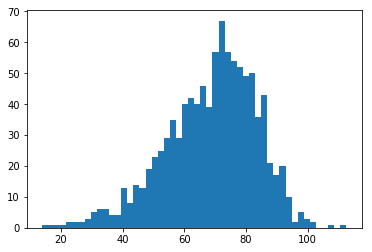

In [18]:
plt.hist(samples, bins=50)

See the "Scale" notebook for an example of moving from sampling to inference using Pyro and Syllog.